In [1]:
#%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
import os
import sys
import jax
jax.config.update("jax_enable_x64", True)
sys.path.append('../synax/')

import synax
import jax.numpy as jnp
import interpax
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import scipy.constants as const

2024-07-03 15:29:59.424711: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## read thermal electrons

In [3]:
dtype = np.float64  # 64-bit floating point
nx,ny,nz = 256,256,64
# Read the binary file
tereg = np.fromfile('../../SyncEmiss/tereg.bin', dtype=dtype).reshape((256,256,64))#.reshape((64,4,64,4,16,4)).mean(axis = (1,3,5))
#ternd = np.fromfile('../../SyncEmiss/ternd.bin', dtype=dtype).reshape((256,256,64))*0#.reshape((64,4,64,4,16,4)).mean(axis = (1,3,5))

breg = np.fromfile('../../SyncEmiss/breg.bin', dtype=dtype).reshape((256,256,64,3))#.reshape((64,4,64,4,16,4,3)).mean(axis = (1,3,5))
brnd = np.fromfile('../../SyncEmiss/brnd.bin', dtype=dtype).reshape((256,256,64,3))#.reshape((64,4,64,4,16,4,3)).mean(axis = (1,3,5))

B_field = breg+brnd
B_field = jnp.ones_like(breg+brnd)*jnp.array([1,0,0])*6e-6
TE_field = tereg#+ternd
#TE_field = jnp.ones_like(TE_field)*0.01

NameError: name 'ternd' is not defined

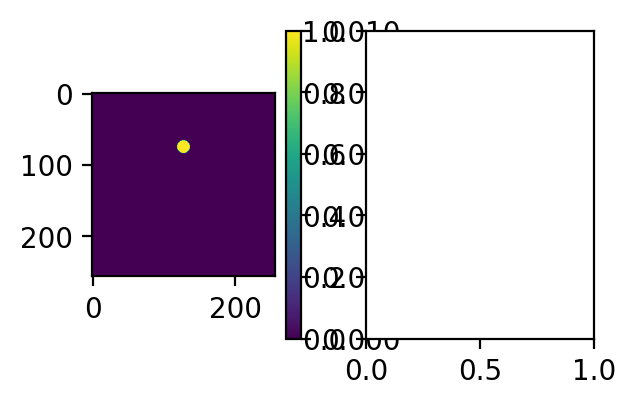

In [4]:
plt.figure(figsize=(5,2),dpi=200)
plt.subplot(131)
plt.imshow(tereg[:,:,8])
plt.colorbar()

plt.subplot(132)
plt.imshow(ternd[:,:,8])
plt.colorbar()

plt.subplot(133)
plt.imshow(tereg[:,:,8]+ternd[:,:,8])
plt.colorbar()

## Calc faraday depth

In [66]:
#const
q_converter = 1/(4*np.pi*const.epsilon_0)**0.5

B_converter = (4*np.pi/const.mu_0)**0.5

freq_irrelavent_const = (const.e*q_converter)**3/(const.electron_mass**2*const.speed_of_light**4)/(2*np.pi)*1e6*1e-4*B_converter*1e19*3.08 # moves 1/cm^3 = 1e6 1/m^3 1 gauss = 1e-4 tesla 1 kpc = 3.08e19 m here.

freq_irrelavent_const

810407283.1937842

In [67]:


xs,step = jnp.linspace(-20,20,nx,endpoint=False,retstep=True)
xs = xs + step*0.5

ys,step = jnp.linspace(-20,20,ny,endpoint=False,retstep=True)
ys = ys + step*0.5

zs,step = jnp.linspace(-5,5,nz,endpoint=False,retstep=True)
zs = zs + step*0.5

In [68]:
coords = jnp.meshgrid(xs,ys,zs,indexing='ij')

In [69]:
def obtain_nhat(x:float,y:float,z:float,obs_coord:tuple[float] = (-8.3,0.,0.006)):
    x_rel = x - obs_coord[0]
    y_rel = y - obs_coord[1]
    z_rel = z - obs_coord[2]
    r = (x_rel**2+y_rel**2+z_rel**2)**0.5
    return jnp.array([x_rel,y_rel,z_rel])/r

obtain_nhat_vamp = jax.vmap(lambda x,y,z:obtain_nhat(x,y,z))

In [70]:
nhats = obtain_nhat_vamp(coords[0].reshape(-1),coords[1].reshape(-1),coords[2].reshape(-1))
nhats = nhats.reshape((nx,ny,nz,3))

In [71]:
B_los = -1*((nhats*B_field)).sum(axis=-1)

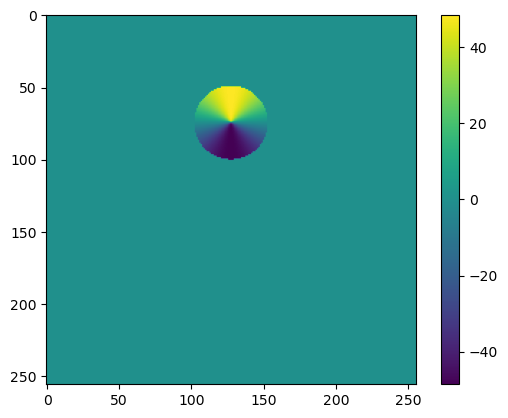

In [72]:
phis = freq_irrelavent_const*TE_field*B_los
plt.imshow(phis[:,:,32])
plt.colorbar()

## Do the integration

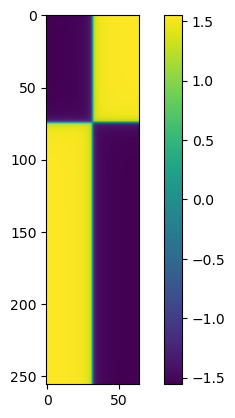

In [73]:
obtain_vmap = jax.vmap(lambda theta,phi:synax.obtain_positions(theta,phi,num_int_points=2048))
nside = 64
n_pixs = np.arange(0,12*nside**2)
theta,phi = hp.pix2ang(nside,n_pixs)
poss,dls = obtain_vmap(theta,phi)


sinb = nhats[:,:,:,2]
cosb = jnp.sqrt(1-sinb**2)
cosl = nhats[:,:,:,0]/cosb
sinl = nhats[:,:,:,1]/cosb

Bz = B_field[...,2]
By = B_field[...,1]
Bx = B_field[...,0]
tanchi0 = (Bz*cosb-sinb*(cosl*Bx+By*sinl))/(Bx*sinl-By*cosl)
chi0 = jnp.arctan(tanchi0)

interp_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,chi0,method='linear',extrap=True))

chi0_interp = interp_3d(poss)
plt.imshow(chi0[:,128,:])
plt.colorbar()

In [74]:
interp_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,phis,method='linear',extrap=True))

In [75]:
%%time
phi_interp = interp_3d(poss)
phi_int = jnp.cumsum(phi_interp,axis=1)*dls[:,jnp.newaxis]

CPU times: user 151 ms, sys: 190 ms, total: 341 ms
Wall time: 388 ms


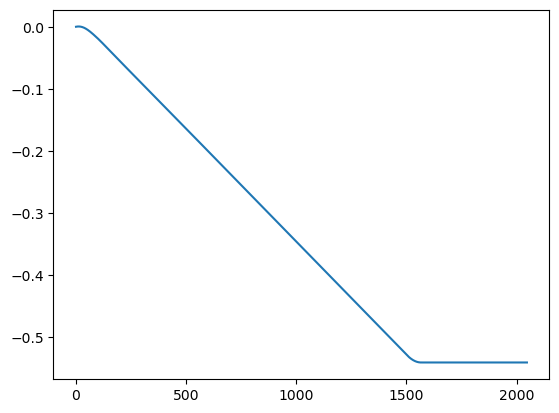

In [76]:
freq = 2.4
fd = phi_int*const.c**2/(freq**2*1e18)
fd_q = jnp.cos(2*fd+2*chi0_interp)
fd_u = jnp.sin(2*fd+2*chi0_interp)
plt.plot(fd[1000])


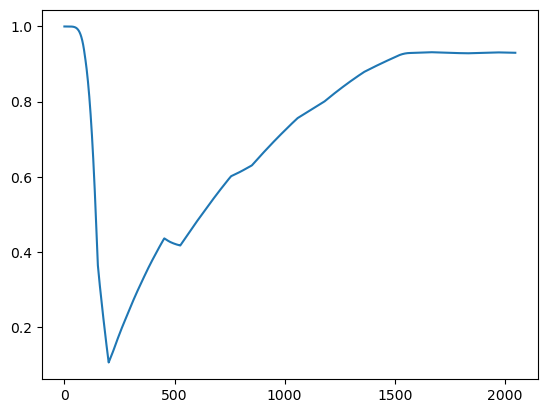

In [77]:
plt.plot(fd_q[1000])

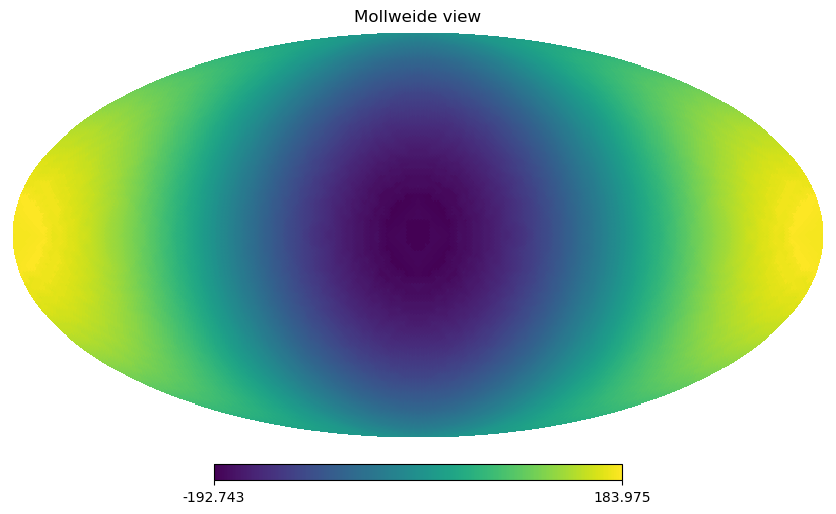

In [78]:
hp.mollview(phi_int[:,-1],norm='hist')

## calc p emissivity

In [79]:
B_field_square = (B_field**2).sum(axis=-1)

B_trans = (B_field_square-B_los**2)**0.5

In [80]:
C_earth = synax.C_page(-8.3,0,0.006)
#C_field = synax.C_page_vmap(coords[0].reshape(-1),coords[1].reshape(-1),coords[2].reshape(-1))*6.4e1/C_earth
C_field = synax.C_uni_vmap(coords[0].reshape(-1),coords[1].reshape(-1),coords[2].reshape(-1))
C_field = C_field.reshape((nx,ny,nz))*4.013285414950239e1

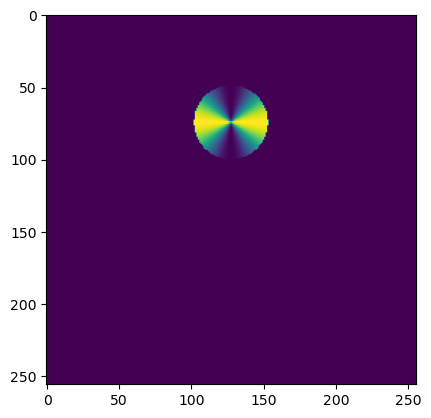

In [81]:
emiss = synax.sync_emiss_P(freq,B_trans,C_field,spectral_index=3.)
plt.imshow(emiss[:,:,32])

In [82]:
interp_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,emiss,method='linear',extrap=True))

In [83]:
%%time
Sync_P_interp = interp_3d(poss)
Sync_Q_int = (Sync_P_interp*fd_q).sum(axis=-1)*dls
Sync_U_int = (Sync_P_interp*fd_u).sum(axis=-1)*dls

CPU times: user 179 ms, sys: 182 ms, total: 361 ms
Wall time: 450 ms


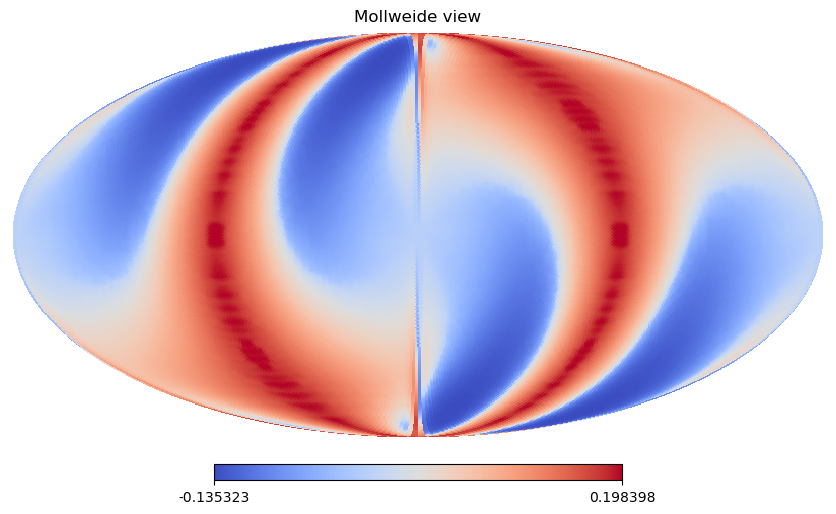

In [84]:
hp.mollview(Sync_Q_int,norm='hist',cmap='coolwarm')

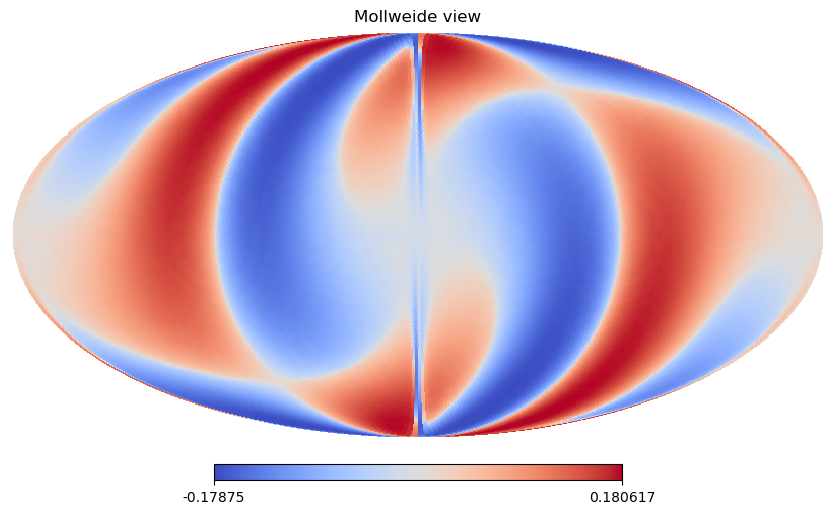

In [85]:
hp.mollview(Sync_U_int,norm='hist',cmap='coolwarm')

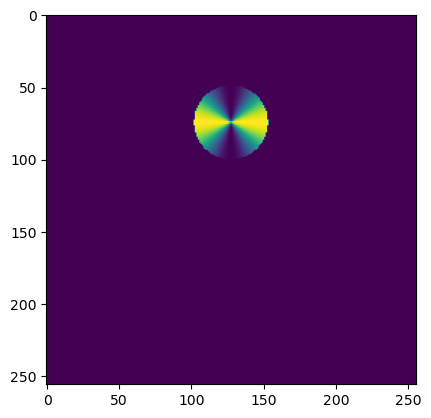

In [25]:
emiss = synax.sync_emiss_I(freq,B_trans,C_field,spectral_index=3.)
plt.imshow(emiss[:,:,32])
interp_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,emiss,method='linear',extrap=True))
Sync_interp = interp_3d(poss)
Sync_int = Sync_interp.sum(axis=-1)*dls

Array(0.2650729, dtype=float64)

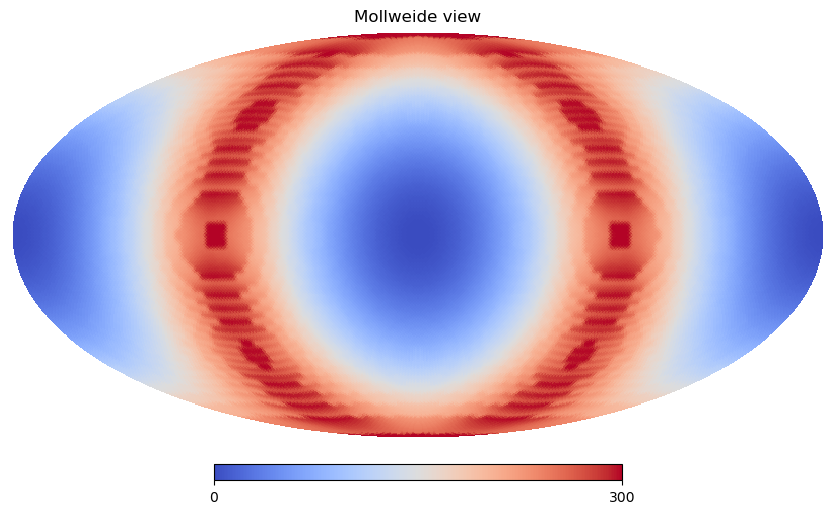

In [54]:
hp.mollview(Sync_int*1e3,min=0,max=300,norm='hist',cmap='coolwarm')
Sync_int.max()

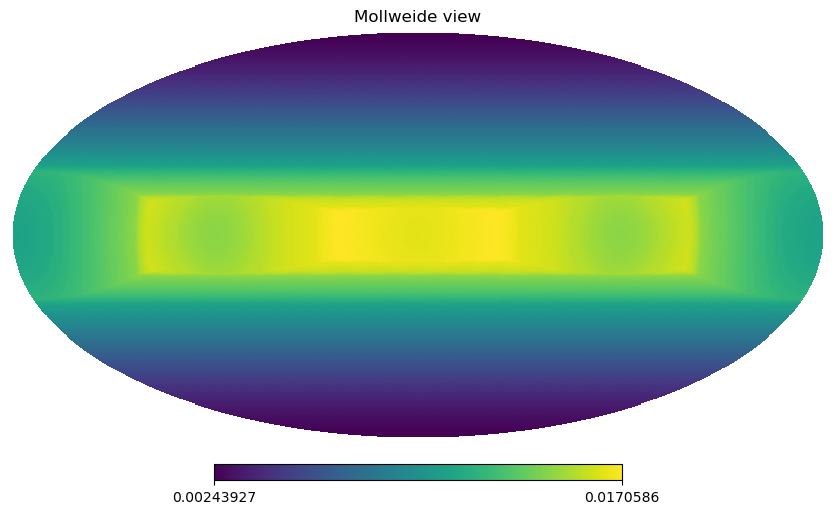

In [27]:
hp.mollview(dls,norm='hist')

In [368]:
dls.min()

Array(0.00243868, dtype=float64)